In [1]:
import synpivimage as spi 
spi.__version__

from pprint import pprint
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt

In [2]:
def plot_img(img, ax):
    im = ax.imshow(img, cmap='gray', vmax=2**cfg.bit_depth)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb = plt.colorbar(im, cax=cax)

In [10]:
cfg = spi.config.SynPivConfig(
    ny=100,
    nx=100,
    bit_depth=8,
    dark_noise=0,
    image_particle_peak_count=200,
    laser_shape_factor=2,
    laser_width=2,
    noise_baseline=0,
    particle_number=int(0.1*100*100),
    particle_position_file='mypositions.txt',
    particle_size_illumination_dependency=True,
    particle_size_mean=2.5,
    particle_size_std=0,
    qe=1.,
    sensitivity=1.,
    shot_noise=True,
    square_image=True)
cfg

SynPivConfig(ny=100, nx=100, square_image=True, bit_depth=8, noise_baseline=0.0, dark_noise=0.0, shot_noise=True, sensitivity=1.0, qe=1.0, particle_number=1000, particle_size_mean=2.5, particle_size_std=0.0, laser_width=2, laser_shape_factor=2, image_particle_peak_count=200, particle_position_file='mypositions.txt', particle_size_illumination_dependency=True)

In [11]:
cfg.particle_size_mean

2.5

In [12]:
out_of_plane_fraction = 0.5

In [13]:
imgA, _, partA = spi.generate_image(
    cfg
)

imgB, _, partB = spi.generate_image(
    cfg,
    particle_data=partA.displace(cfg, dx=0, dy=0, dz=out_of_plane_fraction*cfg.laser_width)
)

Lost particles: 489 (48.9 %)
Lost particles:  489
This is: 48.9 %
Number of particles inside the laser sheet: 1000
ppp: 0.1


In [14]:
# partB.size

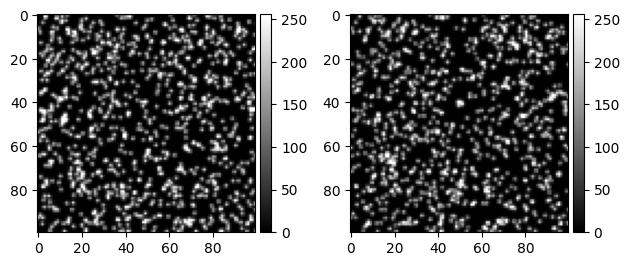

In [15]:
fig, axs = plt.subplots(1, 2)
plot_img(imgA, axs[0])
plot_img(imgB, axs[1])
plt.tight_layout()
plt.show()